# K-Nearest Neighbor Lab

In [25]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io.arff import loadarff
import math
import operator
from numpy import linalg as LNG 
from collections import Counter

# 1. Correctly implement the k-nearest neighbor (KNN) algorithm and the KNN regression algorithm

## Final KNN Class

In [52]:
class KNNClassifier():
    def __init__(self, columntype=[], weight_type='inverse_distance', knn=3, regression=None, total_dataset=None): ## add parameters here

        self.columntype = columntype 
        self.weight_type = weight_type
        self.knn = knn
        self.regression = regression
        self.entire_df = total_dataset
        

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y


    def predict(self, X_test):
        if not self.regression:
            predicted_labels = []
            for point in X_test:
                # if there are homogeneous data types
                if self.columntype == []:
                    distances = LNG.norm(point - self.X_train, axis=1)
                
                else:
                    # get indices for separating columns
                    indices_obj = [i for i, x in enumerate(self.columntype) if x == "object"]
                    indices_float = [i for i, x in enumerate(self.columntype) if x == "float64"]

                    # get standard deviation of numeric columns
                    std_col = self.standard_deviation(self.entire_df, indices_float)
                    std_col = np.array(std_col) # make numpy array
                    std_col_x4 = 4 * std_col # multiply by 4

                    list_cat_distances = self.categorical_distances(self.entire_df)
                    distances = self.heterogeneous_data(point, self.X_train, indices_obj, indices_float, list_cat_distances, std_col_x4)

                # check to see if user specifies inverse distancing
                if self.weight_type != 'inverse_distance':
                    predicted_label = self.voting(self.y_train, distances) 
                    predicted_labels.append(predicted_label)
                else:
                    # weighted_distances = [self.weighted_distances(d) for d in distances] # list comprehension for weighted distances
                    weighted_distances = self.weighted_distances(distances)
                    predicted_label = self.voting(self.y_train, weighted_distances) 
                    predicted_labels.append(predicted_label)

            return predicted_labels
        
        else: 
            predicted_labels = []
            for point in X_test:
                # distances = [self.euclidian_distance(point, x) for x in self.X_train] # list comprehension for distances
                distances = LNG.norm(point - self.X_train, axis=1)
                predicted_label = self.regression_voting(self.y_train, distances) 
                predicted_labels.append(predicted_label)

            return predicted_labels
    

    def categorical_distances(self, df_credit): #kinda lazy with the nomenclature - maybe exclude this from this class amd make an external function...
        #### Implementing Cat Distances IN ENTIRE LOOP THROUGH ALL CAT COLUMNS ####.   N2 Normalized*****
        full_list = []
        for col in indices_obj:
            count_column = df_credit.iloc[:,col].value_counts()
            subsets_1 = []
            subsets_0 = []
            uniq_values = []
            for i, val in count_column.iteritems():
              subset = np.where((df_credit.iloc[:,col] == i) & (df_credit['class'] == 1)) 
              subsets_1.append(subset)
              subset0 = np.where((df_credit.iloc[:,col] == i) & (df_credit['class'] == 0))
              subsets_0.append(subset0)
              uniq_values.append(i)

            value_pairs = []
            list_dist0 = []
            list_dist1 = []
            for i in range(len(uniq_values)):
                for j in range(i + 1, len(uniq_values)):
                    value_pairs.append(uniq_values[i] + uniq_values[j])
                    dist0 = math.sqrt(((len(subsets_0[i][0])/len(df_credit)) - (len(subsets_0[j][0])/len(df_credit)))**2) ## using N2 approach
                    dist1 = math.sqrt(((len(subsets_1[i][0])/len(df_credit)) - (len(subsets_1[j][0])/len(df_credit)))**2)
                    list_dist0.append(dist0)
                    list_dist1.append(dist1)

            sum_lists = np.add(list_dist0, list_dist1)
            dict_distances = dict(zip(value_pairs, sum_lists))

            full_list.append(dict_distances)

        return full_list

    
    def heterogeneous_data(self, point, X_train, indices_obj, indices_float, full_list, std_col):
        total_distance = []
        for idx, val in enumerate(X_train):
            ### categorical distances
            train_instance = X_train[idx,:]

            point_cat = np.delete(point, [indices_float])
            point_cat_train = np.delete(train_instance, [indices_float]) # removing all real columns from X_train

            distance_cat = []
            for i in range(len(indices_obj)-1):
              categorical_combo = point_cat[i] + point_cat_train[i]

              if categorical_combo in full_list[i]:
                distance = full_list[i].get(categorical_combo)
              elif categorical_combo[::-1] in full_list[i]: #check reverse order
                distance = full_list[i].get(categorical_combo[::-1])
              else:
                distance = 0
              distance_cat.append(distance)

            sum_cat_distance = sum(distance_cat)


            ### real data
            point_real = np.delete(point, [indices_obj])
            point_real_train = np.delete(train_instance, [indices_obj])

            # implementing equation 13 from paper (normalized_diff(x, y))
            distance = abs(np.subtract(point_real, point_real_train))
            distance = np.array(distance, dtype=float)
            
            # check if difference contains nan value
            if np.isnan(distance.astype(np.float64)).any():
              distance[np.isnan(distance)] = 1
            
            normalized_diff = sum(np.divide(distance, std_col)) #standard deviation of columns * 4
            
            # add cat and real distances to array
            sum_d = np.add(normalized_diff, sum_cat_distance)
            total_distance.append(sum_d)
          
        return total_distance


    def standard_deviation(self, dataset, indices_float):
        std_columns = []
        for col in indices_float:
            std_col = dataset.iloc[:,col].std()
            std_columns.append(std_col)
        return std_col


    def score(self, y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy


    def mse(self, y_true, y_pred):
        # y_pred = np.array(y_pred) # convert to numpy array in order to perform MSE calc
        return np.average((y_true - y_pred)**2)


    def weighted_distances(self, distances):
        distances = np.array(distances)
        if np.all(distances) == False: # check to see if there are any zero values in the array
            distances = np.where(distances == 0, .01, distances)
            w_distances = np.divide(1,np.square(distances))
        else:
            w_distances = np.divide(1,np.square(distances))
        return w_distances

    def regression_voting(self, y_train, distances):
        if self.weight_type != 'inverse_distance':
            k_indexes = np.argsort(distances)[: self.knn]   # indexes of top k instances
            top_k_values = np.asarray([distances[x] for x in k_indexes])   # get associated values
            avg_distance = np.average(top_k_values)
            return avg_distance
        
        else:
            k_indexes = np.argsort(distances)[: self.knn]   # indexes of top k instances
            top_k_values = np.asarray([distances[x] for x in k_indexes])   # get associated values
            k_neighbor_real_labels = np.asarray([y_train[k] for k in k_indexes])    # get true labels associated with relevant indexes
            y_pred_dist = (np.divide(k_neighbor_real_labels, top_k_values**2).sum())/ (np.divide(1, top_k_values**2).sum())
            return y_pred_dist

    def voting(self, y_train, distances):
        if self.weight_type != 'inverse_distance':
            k_indexes = np.argsort(distances)[: self.knn]
            k_neighbor_labels = [y_train[k] for k in k_indexes]
            winning_label = sorted(Counter(k_neighbor_labels).most_common())[0][0]
            return winning_label

        else:
            k_indexes_sort = np.argsort(distances)[::-1]
            k_indexes = k_indexes_sort[: self.knn]
            top_k_values = [distances[x] for x in k_indexes]
            k_neighbor_labels = [y_train[k] for k in k_indexes]
            final_dict = {}
            for label, value in zip(k_neighbor_labels, top_k_values):
                final_dict[label] = final_dict.get(label, 0) + value
            winning_label = max(final_dict.items(), key=operator.itemgetter(1))[0]
            return winning_label

    

My KNN Clasifier class has as fit() method to define the X and y training data, and  and a predict() method. The predict method loops through each point in the test set and calculates the distance between the point and every point in the training set. Then it calls the voting() and regression_voting() methods to rank the top k values. The heterogeneous_data() method deals with datasets with both real and categorial features. It uses the categorical_distance() method  to get the distances between categorical features, using heterogeneous value difference metric algorithm (N2) to calculate the distances. (more detail is provided in section 5)

## 1.1 Debug and Evaluation

#### 1.1.1 Debug

In [ ]:
## Debug Train
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_train.arff --output debug_train.arff
dataset = loadarff('debug_train.arff')
df_debug = pd.DataFrame(dataset[0])
str_df = df_debug.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_debug[col] = str_df[col]

y = df_debug.iloc[:,-1].to_numpy()
X = df_debug.iloc[:,:-1].to_numpy()


## Debug Test
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/glass_test.arff --output debug_test.arrf
dataset = loadarff('debug_test.arrf')
df_debug_test = pd.DataFrame(dataset[0])
str_df = df_debug_test.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_debug_test[col] = str_df[col]

y_test = df_debug_test.iloc[:,-1].to_numpy()
X_test = df_debug_test.iloc[:,:-1].to_numpy()

In [ ]:
# Without distance weighting

knn_classifier = KNNClassifier(weight_type='uniform')
knn_classifier.fit(X, y)
predicted = knn_classifier.predict(X_test)
score_model = knn_classifier.score(y_test, predicted)
print(f'Accuracy: \t {round(score_model, 5)*100}%')

Accuracy: 	 68.293%


In [ ]:
# Distance weighting

knn_classifier = KNNClassifier()
knn_classifier.fit(X, y)
predicted = knn_classifier.predict(X_test)
score_model = knn_classifier.score(y_test, predicted)
print(f'Accuracy: \t {round(score_model, 5)*100}%')

Accuracy: 	 74.39%


### 1.1.2 Eval

In [ ]:
## Eval Train
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff --output eval_train.arff
dataset = loadarff('eval_train.arff')
df_eval = pd.DataFrame(dataset[0])
str_df = df_eval.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_eval[col] = str_df[col]

y = df_eval.iloc[:,-1].to_numpy()
X = df_eval.iloc[:,:-1].to_numpy()


## Debug Test
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff --output eval_test.arrf
dataset = loadarff('eval_test.arrf')
df_eval_test = pd.DataFrame(dataset[0])
str_df = df_eval_test.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_eval_test[col] = str_df[col]

y_test = df_eval_test.iloc[:,-1].to_numpy()
X_test = df_eval_test.iloc[:,:-1].to_numpy()

In [ ]:
# Without distance weighting - Eval

knn_classifier = KNNClassifier(weight_type='uniform')
knn_classifier.fit(X, y)
predicted = knn_classifier.predict(X_test)
score_model = knn_classifier.score(y_test, predicted)
print(f'Accuracy: \t {round(score_model, 5)*100}%')

Accuracy: 	 76.432%


In [ ]:
# Distance weighting - Eval

knn_classifier = KNNClassifier()
knn_classifier.fit(X, y)
predicted = knn_classifier.predict(X_test)
score_model = knn_classifier.score(y_test, predicted)
print(f'Accuracy: \t {round(score_model, 5)*100}%')

Accuracy: 	 89.062%


# 2. Use the k-nearest neighbor algorithm (without distance weighting) for the magic telescope problem

### Loading Magic Telescope Datasets

In [ ]:
## Magic Train
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff --output magic_train.arff
dataset = loadarff('magic_train.arff')
df_magic = pd.DataFrame(dataset[0])
str_df = df_magic.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_magic[col] = str_df[col]

y = df_magic.iloc[:,-1].to_numpy()
X = df_magic.iloc[:,:-1].to_numpy()


## Magic Test
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff --output magic_test.arrf
dataset = loadarff('magic_test.arrf')
df_magic_test = pd.DataFrame(dataset[0])
str_df = df_magic_test.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_magic_test[col] = str_df[col]

y_test = df_magic_test.iloc[:,-1].to_numpy()
X_test = df_magic_test.iloc[:,:-1].to_numpy()

### 2.1

*   Try it with k=3 and without normalization



In [ ]:
# Magic Telescope: k = 3 & w/o normalization

clf_magic = KNNClassifier(weight_type='uniform') # w/o distance weighting
clf_magic.fit(X, y)
predicted = clf_magic.predict(X_test)
score_model = clf_magic.score(y_test, predicted)
print(f'Accuracy: \t {round(score_model, 5)*100}%')

Accuracy: 	 77.708%


### 2.2 

*   Try it with k=3 and with normalization (input features normalized between 0 and 1). Use the normalization formula (x-xmin)/(xmax-xmin)



In [ ]:
# Magic Telescope - Uniform, k = 3

# Normalizing columns of input features
X_norm = (X - X.min(axis=0))/ (X.max(axis=0) - X.min(axis=0))
X_test_norm = (X_test - X.min(axis=0))/ (X.max(axis=0) - X.min(axis=0)) # USING MIN AND MAX FROM TRAIN - AS EXPLAINED IN THE SLACK CHANNEL

clf_magic_norm = KNNClassifier(weight_type='uniform')
clf_magic_norm.fit(X_norm, y)
predicted = clf_magic_norm.predict(X_test_norm)
score_model = clf_magic_norm.score(y_test, predicted)
print(f'Accuracy: \t {round(score_model, 5)*100}%')

Accuracy: 	 80.003%


Normalizing the data using min-max normalization increased my accuracy by over 2%. Normalizing the features helps avoid certain features with large or small scales from having too much or too little influence on the distances. One of the weaknesses of nearest neighbor is irrelevant features dominating the distances, so normalization is important so this problem isn't exacerbated. However, normalizing the features will not solve all the issues, since each attribute will be weighted equally, regardless of its relevance.

### 2.3

*   Using your normalized data, create one graph with classification accuracy on the test set over k values (odd values 1 - 15)



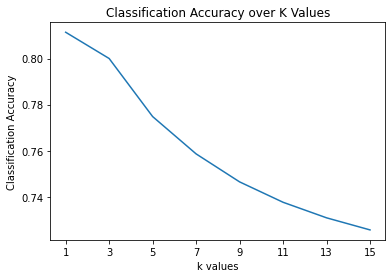

In [ ]:
k_values = []
classification_accuracies = []
for k in range(16):
  if k%2 != 0:
    knn_k = KNNClassifier(weight_type='uniform', knn=k)
    knn_k.fit(X_norm, y)
    predicted = knn_k.predict(X_test_norm)
    score_model = knn_k.score(y_test, predicted)
        
    classification_accuracies.append(score_model)
    k_values.append(k)

# Plot accuracies and k values
plt.plot(k_values, classification_accuracies)
plt.xticks(np.arange(min(k_values), max(k_values)+1, 2))
plt.title("Classification Accuracy over K Values")
plt.xlabel("k values")
plt.ylabel("Classification Accuracy")
plt.show()


With uniform weights, my accuracy decreased with each increase in k. More on this in section 4 

# 3. Use the regression variation of your algorithm (without distance weighting) for the housing price prediction problem.

### Loading Housing Datasets

In [ ]:
## Housing Train
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff --output housing_train.arff
dataset = loadarff('housing_train.arff')
df_housing = pd.DataFrame(dataset[0])
str_df = df_housing.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_housing[col] = str_df[col]

df_housing_train = df_housing.copy()

# Normalizing
df_housing_train = df_housing_train.astype({'CHAS': 'float64'})

for col in df_housing:
  if col not in ['CHAS','MEDV']:
    df_housing_train[col] =(df_housing_train[col]-df_housing[col].min())/(df_housing[col].max()-df_housing[col].min())

y = df_housing_train.iloc[:,-1].to_numpy()
X = df_housing_train.iloc[:,:-1].to_numpy()


## Housing Test
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff --output housing_test.arrf
dataset = loadarff('housing_test.arrf')
df_housing_test = pd.DataFrame(dataset[0])
str_df = df_housing_test.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_housing_test[col] = str_df[col]

# Normalizing
df_housing_test = df_housing_test.astype({'CHAS': 'float64'})
for col in df_housing_test:
  if col not in ['CHAS','MEDV']:
    df_housing_test[col] =(df_housing_test[col]-df_housing[col].min())/(df_housing[col].max()-df_housing[col].min()) ## USING MIN AND MAX FROM TRAIN

y_test = df_housing_test.iloc[:,-1].to_numpy()
X_test = df_housing_test.iloc[:,:-1].to_numpy()

### Running model with k values from 1-15

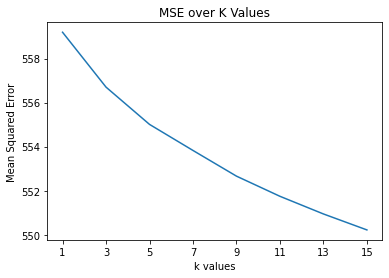

In [ ]:
## Housing Data: No Distance Weighting & k-values 1 - 15

k_values = []
mse_accuracies = []

# Training models
for k in range(16):
  if k%2 != 0:
    knn_regression_k = KNNClassifier(weight_type='uniform', knn=k, regression=True) # no distance weighting
    knn_regression_k.fit(X, y)
    predicted = knn_regression_k.predict(X_test)
    score_model = knn_regression_k.mse(y_test, predicted)
        
    mse_accuracies.append(score_model)
    k_values.append(k)


# Plotting MSE over k values
plt.plot(k_values, mse_accuracies)
plt.xticks(np.arange(min(k_values), max(k_values)+1, 2))
plt.title("MSE over K Values")
plt.xlabel("k values")
plt.ylabel("Mean Squared Error")
plt.show()

The MSE decreased with each additional k throughout my model. Since I was using uniform rather than distance weighting, my MSE is fairly large. I assume this is because it is much more difficult to get accurate predictions by taking the average label of the k nearest neighbors. Using distance weighting should give a more accurate prediction by weighting points by the inverse of their distance. This way, closer points have more weight and farther points have less weight, rather than arbitrarilly giving all k neighbors equal weighting. 

# 4. Repeat your experiments for magic telescope and housing using distance-weighted (inverse of distance squared) voting and discuss your results.

## 4.1 Magic Telescope Dataset

In [ ]:
## Loading Data

# Magic Train
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff --output magic_train.arff
dataset = loadarff('magic_train.arff')
df_magic = pd.DataFrame(dataset[0])
str_df = df_magic.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_magic[col] = str_df[col]

y = df_magic.iloc[:,-1].to_numpy()
X = df_magic.iloc[:,:-1].to_numpy()


# Magic Test
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff --output magic_test.arrf
dataset = loadarff('magic_test.arrf')
df_magic_test = pd.DataFrame(dataset[0])
str_df = df_magic_test.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_magic_test[col] = str_df[col]

y_test = df_magic_test.iloc[:,-1].to_numpy()
X_test = df_magic_test.iloc[:,:-1].to_numpy()


X_norm = (X - X.min(axis=0))/ (X.max(axis=0) - X.min(axis=0))
X_test_norm = (X_test - X.min(axis=0))/ (X.max(axis=0) - X.min(axis=0)) # USING MIN AND MAX FROM TRAIN



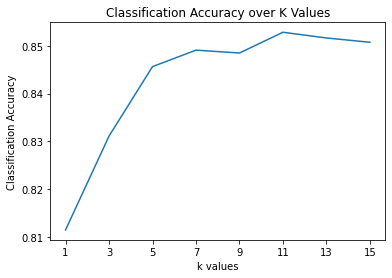

In [ ]:
## Magic Telescope Data: Distance Weighting & k values 1 - 15 
k_values = []
classification_accuracies = []
for k in range(16):
  if k%2 != 0:
    knn_k = KNNClassifier(weight_type='inverse_distance', knn=k)
    knn_k.fit(X_norm, y)
    predicted = knn_k.predict(X_test_norm)
    score_model = knn_k.score(y_test, predicted)
        
    classification_accuracies.append(score_model)
    k_values.append(k)


# Plot accuracies and k values
plt.plot(k_values, classification_accuracies)
plt.xticks(np.arange(min(k_values), max(k_values)+1, 2))
plt.title("Classification Accuracy over K Values")
plt.xlabel("k values")
plt.ylabel("Classification Accuracy")
plt.show()

In contrast to part 2, where the accuracy of nearest neighbor model (using uniform distance weighting) decreased with each increase in k, implementing distance weighting showed the accuracy increases as k increases. After allowing more than 11 neighbors to have an influence on the "voting" the accuracy starts declining. This is what I would expect to see since this would cause unrelated neighbors that are likely unrelated to influence the output. 

## 4.2 Housing Dataset

In [ ]:
## Housing Train
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff --output housing_train.arff
dataset = loadarff('housing_train.arff')
df_housing = pd.DataFrame(dataset[0])
str_df = df_housing.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_housing[col] = str_df[col]

df_housing_train = df_housing.copy()

# Normalizing
df_housing_train = df_housing_train.astype({'CHAS': 'float64'})

for col in df_housing:
  if col not in ['CHAS','MEDV']:
    df_housing_train[col] =(df_housing_train[col]-df_housing[col].min())/(df_housing[col].max()-df_housing[col].min())

y = df_housing_train.iloc[:,-1].to_numpy()
X = df_housing_train.iloc[:,:-1].to_numpy()


## Housing Test
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff --output housing_test.arrf
dataset = loadarff('housing_test.arrf')
df_housing_test = pd.DataFrame(dataset[0])
str_df = df_housing_test.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_housing_test[col] = str_df[col]

# Normalizing
df_housing_test = df_housing_test.astype({'CHAS': 'float64'})
for col in df_housing_test:
  if col not in ['CHAS','MEDV']:
    df_housing_test[col] =(df_housing_test[col]-df_housing[col].min())/(df_housing[col].max()-df_housing[col].min()) ## USING MIN AND MAX FROM TRAIN

y_test = df_housing_test.iloc[:,-1].to_numpy()
X_test = df_housing_test.iloc[:,:-1].to_numpy()

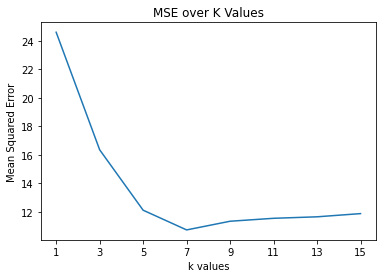

In [ ]:
## Housing Data: Distance Weighting & k values 1 - 15 
k_values = []
mse_accuracies = []

# Training models
for k in range(16):
  if k%2 != 0:
    knn_regression_k = KNNClassifier(weight_type='inverse_distance', knn=k, regression=True)
    knn_regression_k.fit(X, y)
    predicted = knn_regression_k.predict(X_test)
    score_model = knn_regression_k.mse(y_test, predicted)
        
    mse_accuracies.append(score_model)
    k_values.append(k)


# Method to plot values
plt.plot(k_values, mse_accuracies)
plt.xticks(np.arange(min(k_values), max(k_values)+1, 2))
plt.title("MSE over K Values")
plt.xlabel("k values")
plt.ylabel("Mean Squared Error")
plt.show()

Using distance weighting increased the accuracy of my model tremendously. In section 3 the MSE was was between 560 and 550. With distance weighting, the nearest neigbhor model's MSE goes down to below 12 when k = 7. Distance weighting is much more effective than simply taking the average of the top k votes (as was done in section 3) because it makes the strength of a neighbor's influence proportional to its distance. 

As I mentioned in section 4.2, I am not surprised to find that after a certain k value, the model's accruacy starts to decrease. This is because it starts allowing more and more neigbors to vote, increased the liklihood that unrelated neighbors influence the target. 

# 5. Use the k-nearest neighbor algorithm to solve the credit-approval (credit-a) problem.

### Loading Credit Approval Dataset

In [ ]:
# Credit Approval
from sklearn.model_selection import train_test_split

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff --output credit.arff
dataset = loadarff('credit.arff')
df_credit = pd.DataFrame(dataset[0])
str_df = df_credit.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_credit[col] = str_df[col]

df_credit.loc[df_credit['class'] == '+', 'class'] = 1
df_credit.loc[df_credit['class'] == '-', 'class'] = 0

# normalize df_credit data 
column_types = list(df_credit.dtypes)[:-1] # grabbing column types to use as parameter in KNNCLassifier() class
indices_obj = [i for i, x in enumerate(column_types) if x == "object"] # indices of object features
indices_float = [i for i, x in enumerate(column_types) if x == "float64"] # indices of float features

col_to_normalize = [df_credit.columns[x] for x in indices_float] # list of column names to normalize (i.e. real valued features)
df_credit[col_to_normalize] = df_credit[col_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min())) # normalize - using lambda function


y = df_credit.iloc[:,-1].to_numpy()
X = df_credit.iloc[:,:-1].to_numpy()

# Create splits - using sklearn's package
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Running Model

In [53]:
### Running KNNClassifier Model
##- Using Heterogeneous Value Difference Metric (N2 approach) - Treating '?' cat varibales as additional feature types rather than returning a distance of 1 by default

clf_credit = KNNClassifier_test(columntype=column_types, weight_type='inverse_distance', knn=3, total_dataset=df_credit)
clf_credit.fit(X_train, y_train)
predicted = clf_credit.predict(X_test)
score_model = clf_credit.score(y_test, predicted)
print(f'Accuracy: \t {round(score_model, 5)*100}%')

Accuracy: 	 79.71000000000001%


I used the heterogeneous value difference metric (HVDM) from the linked paper in the directions. Since neither euclidean distance or VDM is appropriate for datasets with both nominal and continuous data, HVDM is an effective "hybrid" approach. I did make some adjustments to the HVDM function. Rather than returning a 1 if x or y is unknown for both categoricl and real features, I treated unknown ('?') categorical varaibles as new features entirely when using the N2 approach (normalized_vdm). For continous features, I used the normalized_diff(x,y) function (equation 13 in the linked paper)

# 6. Use the scikit's KNN Classifier on magic telescope and KNN Regressor on housing and compare your results.

*   Try out different hyperparameters to see how well you can do.



## Magic Telescope

### Loading Datasets and Nomalizing

In [ ]:
## Magic Train
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff --output magic_train.arff
dataset = loadarff('magic_train.arff')
df_magic = pd.DataFrame(dataset[0])
str_df = df_magic.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_magic[col] = str_df[col]

y = df_magic.iloc[:,-1].to_numpy()
X = df_magic.iloc[:,:-1].to_numpy()


## Magic Test
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff --output magic_test.arrf
dataset = loadarff('magic_test.arrf')
df_magic_test = pd.DataFrame(dataset[0])
str_df = df_magic_test.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_magic_test[col] = str_df[col]

y_test = df_magic_test.iloc[:,-1].to_numpy()
X_test = df_magic_test.iloc[:,:-1].to_numpy()

# Normalizing columns of input features
X_norm = (X - X.min(axis=0))/ (X.max(axis=0) - X.min(axis=0))
X_test_norm = (X_test - X.min(axis=0))/ (X.max(axis=0) - X.min(axis=0))

### Running sklearn model

Accuracy of sklearn's model testing k=3 and distance vs. uniform is a few points higher than my model

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

knn = KNeighborsClassifier(n_neighbors=3, weights='uniform')
knn.fit(X_norm, y)
y_pred = knn.predict(X_test_norm)
score = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: \t {round(score, 5)*100}%')

Accuracy: 	 83.063%


In [56]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(X_norm, y)
y_pred = knn.predict(X_test_norm)
score = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: \t {round(score, 5)*100}%')

Accuracy: 	 83.258%


Testing effect of distance metric - Manhattan distance does the best

In [28]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='manhattan')
knn.fit(X_norm, y)
y_pred = knn.predict(X_test_norm)
score = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: \t {round(score, 5)*100}%')

Accuracy: 	 83.903%


In [29]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='euclidean')
knn.fit(X_norm, y)
y_pred = knn.predict(X_test_norm)
score = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: \t {round(score, 5)*100}%')

Accuracy: 	 83.258%


In [33]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='minkowski', p=3)
knn.fit(X_norm, y)
y_pred = knn.predict(X_test_norm)
score = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: \t {round(score, 5)*100}%')

Accuracy: 	 83.123%


Testing various k values on the manhattan distance 83.901% model

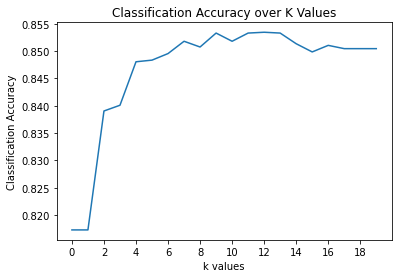



Best Accuracy: 	 85.344% at k = 12


In [47]:
accuracy_list = []
k_values = []
for k in range(20):
    knn = KNeighborsClassifier(n_neighbors=(k+1), weights='distance', metric='manhattan')
    knn.fit(X_norm, y)
    y_pred = knn.predict(X_test_norm)
    score = metrics.accuracy_score(y_test, y_pred)
    accuracy_list.append(score)
    k_values.append(k)

# print(f'Accuracy: \t {round(score, 5)*100}%')
# Plot accuracy
# Plot accuracies and k values
plt.plot(k_values, accuracy_list)
plt.xticks(np.arange(min(k_values), max(k_values)+1, 2))
plt.title("Classification Accuracy over K Values")
plt.xlabel("k values")
plt.ylabel("Classification Accuracy")
plt.show()
print()
print()


# find max k and max accuracy
max_acc = max(accuracy_list)
best_k = accuracy_list.index(max_acc)
print(f'Best Accuracy: \t {round(max_acc, 5)*100}% at k = {best_k}')


Surprisingly, the manhattan distance metric performed better than euclidean and minkowski. The accuracy increased marginally between the uniform weight values vs the distance weighting. In my model in section 2, the accuracy increased by around 2%. 

After running my best performing model (with hyperparameters of (weights='distance', metric='manhattan'), I found that k = 12 performed the beset.

## Housing Data

### Loading Datasets

In [48]:
## Housing Train
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff --output housing_train.arff
dataset = loadarff('housing_train.arff')
df_housing = pd.DataFrame(dataset[0])
str_df = df_housing.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_housing[col] = str_df[col]

df_housing_train = df_housing.copy()

# Normalizing
df_housing_train = df_housing_train.astype({'CHAS': 'float64'})

for col in df_housing:
  if col not in ['CHAS','MEDV']:
    df_housing_train[col] =(df_housing_train[col]-df_housing[col].min())/(df_housing[col].max()-df_housing[col].min())

y = df_housing_train.iloc[:,-1].to_numpy()
X = df_housing_train.iloc[:,:-1].to_numpy()


## Housing Test
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff --output housing_test.arrf
dataset = loadarff('housing_test.arrf')
df_housing_test = pd.DataFrame(dataset[0])
str_df = df_housing_test.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_housing_test[col] = str_df[col]

# Normalizing
df_housing_test = df_housing_test.astype({'CHAS': 'float64'})
for col in df_housing_test:
  if col not in ['CHAS','MEDV']:
    df_housing_test[col] =(df_housing_test[col]-df_housing[col].min())/(df_housing[col].max()-df_housing[col].min()) ## USING MIN AND MAX FROM TRAIN

y_test = df_housing_test.iloc[:,-1].to_numpy()
X_test = df_housing_test.iloc[:,:-1].to_numpy()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34205  100 34205    0     0  88157      0 --:--:-- --:--:-- --:--:-- 87930
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3885  100  3885    0     0   9860      0 --:--:-- --:--:-- --:--:--  9860


### Fitting and Scoring Model Using Sklearn

In [57]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 


neigh_regressor = KNeighborsRegressor(n_neighbors=5)
neigh_regressor.fit(X, y)
prediction = neigh_regressor.predict(X_test)
score_model = neigh_regressor.score(X_test, y_test)
print(f'R-squared: \t {round(score_model, 5)}')
print(f'MSE: \t\t {round(mean_squared_error(y_test, prediction), 5)}')


R-squared: 	 0.79258
MSE: 		 15.89698


In [58]:
neigh_regressor = KNeighborsRegressor(n_neighbors=5, weights='distance')
neigh_regressor.fit(X, y)
prediction = neigh_regressor.predict(X_test)
score_model = neigh_regressor.score(X_test, y_test)
print(f'R-squared: \t {round(score_model, 5)}')
print(f'MSE: \t\t {round(mean_squared_error(y_test, prediction), 5)}')

R-squared: 	 0.84118
MSE: 		 12.17196


Testing effect of distance metric - Manhattan distance does the best

In [59]:
neigh_regressor = KNeighborsRegressor(n_neighbors=5, weights='distance', metric='manhattan')
neigh_regressor.fit(X, y)
prediction = neigh_regressor.predict(X_test)
score_model = neigh_regressor.score(X_test, y_test)
print(f'R-squared: \t {round(score_model, 5)}')
print(f'MSE: \t\t {round(mean_squared_error(y_test, prediction), 5)}')

R-squared: 	 0.8579
MSE: 		 10.89071


In [60]:
neigh_regressor = KNeighborsRegressor(n_neighbors=5, weights='distance', metric='euclidean')
neigh_regressor.fit(X, y)
prediction = neigh_regressor.predict(X_test)
score_model = neigh_regressor.score(X_test, y_test)
print(f'R-squared: \t {round(score_model, 5)}')
print(f'MSE: \t\t {round(mean_squared_error(y_test, prediction), 5)}')

R-squared: 	 0.84118
MSE: 		 12.17196


In [61]:
neigh_regressor = KNeighborsRegressor(n_neighbors=5, weights='distance',metric='minkowski', p=3)
neigh_regressor.fit(X, y)
prediction = neigh_regressor.predict(X_test)
score_model = neigh_regressor.score(X_test, y_test)
print(f'R-squared: \t {round(score_model, 5)}')
print(f'MSE: \t\t {round(mean_squared_error(y_test, prediction), 5)}')

R-squared: 	 0.82161
MSE: 		 13.67207


Testing various k values on the manhattan distance distance weighted model

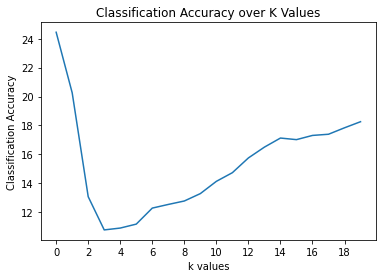



Best MSE: 10.76206 at k = 3
R-squared at k= 3: 0.85958


In [70]:
rsqr_list = []
mse_list = []
k_values = []
for k in range(20):
    neigh_regressor = KNeighborsRegressor(n_neighbors=(k+1), weights='distance', metric='manhattan')
    neigh_regressor.fit(X, y)
    y_pred = neigh_regressor.predict(X_test)
    score = neigh_regressor.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)

    rsqr_list.append(score)
    mse_list.append(mse)
    k_values.append(k)


# Plot accuracies and k values
plt.plot(k_values, mse_list)
plt.xticks(np.arange(min(k_values), max(k_values)+1, 2))
plt.title("Classification Accuracy over K Values")
plt.xlabel("k values")
plt.ylabel("Classification Accuracy")
plt.show()
print()
print()


# find max k and max accuracy
min_mse = min(mse_list)
best_k = mse_list.index(min_mse)
best_rsqr = rsqr_list[best_k]
print(f'Best MSE: {round(min_mse, 5)} at k = {best_k}')
print(f'R-squared at k= {best_k}: {round(best_rsqr, 5)}')

Just like with th Telescope dataset, the distance weighting performed better than the uniform weightin. I was also surprised that the manhattan distance metric also performed better than euclidean and minkowski for the housing dataset. 

After running my best performing model (with hyperparameters of (weights='distance', metric='manhattan'), I found that k = 3 performed the best (refer to graph above). Although I did not end up many of the hyperparameters in my final "best" model, I did try the other parameters and did not find any increase in accuracy. 